In [25]:
%%markdown
source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

NOTES:
* the ImageFolder class from torchvision.datasets works only when the data is in the current directory

source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

NOTES:
* the ImageFolder class from torchvision.datasets works only when the data is in the current directory

In [22]:
# official version

from torchvision import transforms,datasets
import os

#data loader
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val' : transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets)

<class 'torchvision.datasets.folder.ImageFolder'>
{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root Location: ./hymenoptera_data/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root Location: ./hymenoptera_data/val
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             

Epoch 0/24
----------
train Loss: 0.6408 Acc: 0.6516
test Loss: 0.3867 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5193 Acc: 0.7459
test Loss: 0.1646 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3017 Acc: 0.8770
test Loss: 0.2362 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4639 Acc: 0.8443
test Loss: 0.2841 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5333 Acc: 0.7787
test Loss: 0.2406 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3258 Acc: 0.8648
test Loss: 0.2880 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4953 Acc: 0.8197
test Loss: 0.4559 Acc: 0.8170

Epoch 7/24
----------
train Loss: 0.4157 Acc: 0.8361
test Loss: 0.2252 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4373 Acc: 0.7992
test Loss: 0.1891 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3923 Acc: 0.8443
test Loss: 0.1816 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2702 Acc: 0.8852
test Loss: 0.1965 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3376 Acc: 0.8525
test Loss: 0.1886 Acc

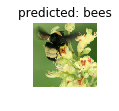

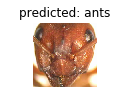

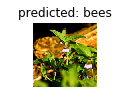

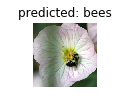

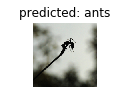

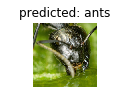

In [52]:
# test version
from torchvision import transforms,datasets,models
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

################### data loader ########################

data_transform_train = transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transforms_test = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir_train = './hymenoptera_data/train'
image_datasets_train = datasets.ImageFolder(data_dir_train,data_transforms_train)

data_dir_test = './hymenoptera_data/val'
image_datasets_test = datasets.ImageFolder(data_dir_test,data_transforms_test)

data_loader_train = torch.utils.data.DataLoader(image_datasets_train,batch_size = 4,shuffle=True,num_workers=4)
data_loader_test = torch.utils.data.DataLoader(image_datasets_test,batch_size = 4,shuffle=True,num_workers=4)

dataset_sizes = {'train':len(image_datasets_train),'test':len(image_datasets_test)} #{'train': 244, 'test': 153}
class_names = image_datasets_train.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_loaders = {'train':data_loader_train,'test':data_loader_test}

################ img visialization #######################

def img_show(inp,title=None):
    #inp is a torch tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# inputs, classes = next(iter(data_loader_train))
# out = torchvision.utils.make_grid(inputs)
# img_show(out, title=[class_names[x] for x in classes])

#################### trainer #################################
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
             # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            
################################ visualizing some images ################################
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                img_show(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
############################ finetuning ConvNet ########################

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

####################### train and evaluate #################################
model_conv = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
visualize_model(model_conv)